In [1]:
import torch
from torch import nn


from torch.utils.data import DataLoader


from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import Accuracy
from mlxtend.plotting import plot_confusion_matrix
from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2023-11-02 21:01:47.322532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 21:01:48.164868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = datasets.CIFAR10("dataset", download=True, train=True, transform=transform_train)
test_data = datasets.CIFAR10("dataset", download=True, train=False , transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# seeing train data
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [4]:
# seeing test data
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataset
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [5]:
## seeing objects
obj_class = train_data.classes
obj_class

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
train_data[0][0].shape

torch.Size([3, 32, 32])

## In the simplest case, the output value of the layer with input size.

### Batch, channel, height, width

In [7]:
train_data[0][0].shape ## all ready in format

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


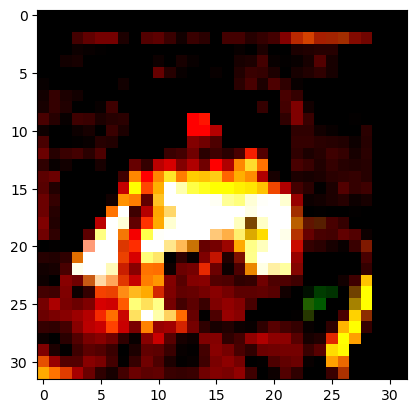

In [8]:
## changing format for vizualation
trans_img = np.transpose(train_data[0][0], [1,2,0]) # transpose (H, W, C)
plt.imshow(trans_img)

In [9]:
train_data.data[0].shape

(32, 32, 3)

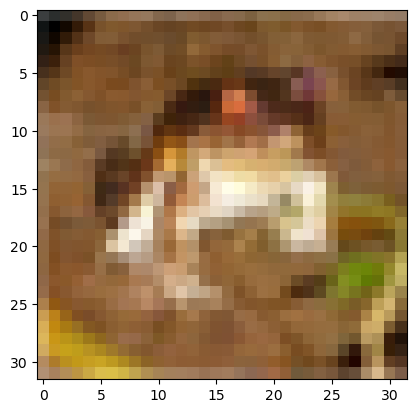

In [10]:
plt.imshow(train_data.data[0])

In [11]:
train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=32, num_workers=4)
test_loader = DataLoader(dataset=test_data, shuffle=True, batch_size=32, num_workers=4)

In [12]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [13]:
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataset
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


airplane


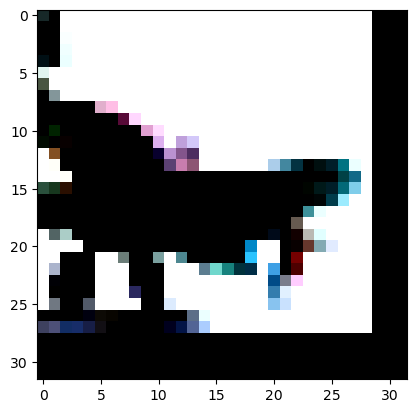

In [14]:
for X,y in train_loader:
    plt.imshow(np.transpose(X[0], [1,2,0]))
    print(obj_class[y[0]])
    break

In [15]:
## model

class CNNCIFAR10_CLF(nn.Module):
    def __init__(self, inp_shape, cnn_hidden_shape, classif_hiiden_shape, out_shape):
        super().__init__()
        
        self.inp_shape = inp_shape
        self.cnn_hidden_shape = cnn_hidden_shape
        self.classif_hiiden_shape = classif_hiiden_shape
        self.out_shape = out_shape
        
        ## cnn block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(inp_shape, cnn_hidden_shape, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(cnn_hidden_shape, cnn_hidden_shape, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        
        cnn_hidden_shape*=2
        self.block2 = nn.Sequential(
            nn.Conv2d(cnn_hidden_shape//2, cnn_hidden_shape, 2),
            nn.ReLU(),
            nn.Conv2d(cnn_hidden_shape, cnn_hidden_shape, 2, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        
        cnn_hidden_shape*=2
        self.block3 = nn.Sequential(
            nn.Conv2d(cnn_hidden_shape//2, cnn_hidden_shape, 2),
            nn.ReLU(),
            nn.Conv2d(cnn_hidden_shape, cnn_hidden_shape, 2, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        cnn_hidden_shape //= 2
        self.classif = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=cnn_hidden_shape*8*8, out_features=classif_hiiden_shape),
            nn.ReLU(),
            nn.Linear(classif_hiiden_shape, 500),
            nn.ReLU(),
            nn.Linear(500, out_shape)
        )
    
#     def classification_layer(self, x):
#         self.flat = nn.Flatten()
#         self.l1 = nn.Linear(in_features=self.flat(x).shape[1], out_features=self.classif_hiiden_shape).to(device)
#         self.l2 = nn.Linear(self.classif_hiiden_shape, 500).to(device)
#         self.l3 = nn.Linear(500, self.out_shape).to(device)
#         self.relu = nn.ReLU()
        
#         x = self.flat(x)
# #         print("xxx", x, x.shape)
#         x = self.l1(x)
#         x = self.relu(x)
#         x = self.l2(x)
#         x = self.relu(x)
#         x = self.l3(x)
#         return(x)
        
    def forward(self, x):
        x = self.block1(x)
#         print("Block 1:", x.shape)
        x = self.block2(x)
#         print("Block 2:", x.shape)
        
        X = self.block3(x)
#         print(x.shape)
        
#         self.calc_flat_inp(x)
        x = self.classif(x)
#         print("classif:", x.shape)
        return x

In [16]:
model0 = CNNCIFAR10_CLF(inp_shape=3,
                       cnn_hidden_shape=16,
                       classif_hiiden_shape=1000,
                       out_shape=len(obj_class)).to(device)

model0 = nn.DataParallel(model0)

In [17]:
sum(p.numel() for p in model0.parameters()) # total prams

2588190

In [18]:
sum(p.numel() for p in model0.parameters() if p.requires_grad) # trainable_prams

2588190

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


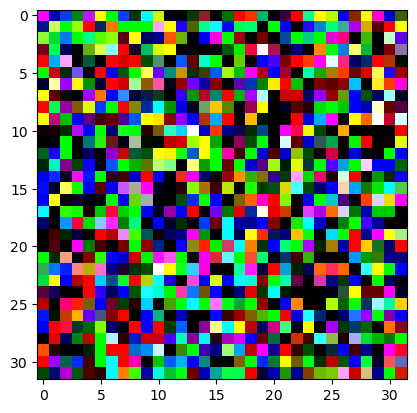

In [19]:
## temp data
tmp_img = torch.randn([1,3,32,32])

plt.imshow(np.transpose(tmp_img[0], [1,2,0]))

In [20]:
model0(tmp_img.to(device))

tensor([[-0.0435,  0.0457, -0.0274, -0.0383,  0.0125, -0.0384, -0.0042, -0.0020,
         -0.0002, -0.0440]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
## loss and optim

In [22]:
loss_fn = nn.CrossEntropyLoss()
optim_fn = torch.optim.Adam(params=model0.parameters(), lr=0.0001)

In [23]:
acc_score = Accuracy(task="multiclass", num_classes=len(obj_class)).to(device)

In [24]:
## train loop
import time

epochs = 100
for e in range(epochs):
    start = time.time()
    model0.train()
    
    train_loss, train_acc = 0,0
    for X_tr, y_tr in train_loader:
        X_tr, y_tr = X_tr.to(device), y_tr.to(device)
        
        y_logits = model0(X_tr)
        loss = loss_fn(y_logits, y_tr)
        
        train_loss +=loss
        train_acc += acc_score(y_logits, y_tr)
        
        optim_fn.zero_grad()
        loss.backward()
        optim_fn.step()
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    model0.eval()
    test_loss, test_acc = 0,0
    for X_te, y_te in test_loader:
        X_te, y_te = X_te.to(device), y_te.to(device)
        
        y_temp = model0(X_te)
        test_loss += loss_fn(y_temp, y_te)
        test_acc += acc_score(y_temp, y_te)
    
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    
    print(f"Epoch: {e} | Train_loss: {train_loss:.2f} | Test_loss: {test_loss:.2f} | Train_acc: {train_acc*100:.2f} | Test_acc: {test_acc*100:.2f} | Tot_Time: {time.time()-start}")
        

Epoch: 0 | Train_loss: 1.78 | Test_loss: 1.55 | Train_acc: 34.98 | Test_acc: 42.59 | Tot_Time: 6.870547294616699
Epoch: 1 | Train_loss: 1.50 | Test_loss: 1.38 | Train_acc: 44.98 | Test_acc: 49.51 | Tot_Time: 6.500678062438965
Epoch: 2 | Train_loss: 1.40 | Test_loss: 1.29 | Train_acc: 49.08 | Test_acc: 53.17 | Tot_Time: 6.738807678222656
Epoch: 3 | Train_loss: 1.31 | Test_loss: 1.20 | Train_acc: 52.41 | Test_acc: 57.15 | Tot_Time: 6.851980209350586
Epoch: 4 | Train_loss: 1.24 | Test_loss: 1.12 | Train_acc: 55.26 | Test_acc: 59.62 | Tot_Time: 6.854910850524902
Epoch: 5 | Train_loss: 1.18 | Test_loss: 1.06 | Train_acc: 57.57 | Test_acc: 61.46 | Tot_Time: 6.960414409637451
Epoch: 6 | Train_loss: 1.11 | Test_loss: 1.02 | Train_acc: 60.09 | Test_acc: 64.06 | Tot_Time: 6.8390302658081055
Epoch: 7 | Train_loss: 1.07 | Test_loss: 0.97 | Train_acc: 61.70 | Test_acc: 65.52 | Tot_Time: 6.931263446807861
Epoch: 8 | Train_loss: 1.03 | Test_loss: 0.93 | Train_acc: 63.06 | Test_acc: 67.06 | Tot_Time: 

Epoch: 72 | Train_loss: 0.30 | Test_loss: 0.67 | Train_acc: 89.46 | Test_acc: 81.09 | Tot_Time: 6.858785152435303
Epoch: 73 | Train_loss: 0.29 | Test_loss: 0.68 | Train_acc: 89.58 | Test_acc: 80.44 | Tot_Time: 7.521502256393433
Epoch: 74 | Train_loss: 0.29 | Test_loss: 0.68 | Train_acc: 89.72 | Test_acc: 80.38 | Tot_Time: 7.585809946060181
Epoch: 75 | Train_loss: 0.28 | Test_loss: 0.68 | Train_acc: 89.98 | Test_acc: 80.86 | Tot_Time: 7.061185598373413
Epoch: 76 | Train_loss: 0.28 | Test_loss: 0.69 | Train_acc: 90.22 | Test_acc: 81.00 | Tot_Time: 7.07199239730835
Epoch: 77 | Train_loss: 0.28 | Test_loss: 0.69 | Train_acc: 90.14 | Test_acc: 80.40 | Tot_Time: 6.749029159545898
Epoch: 78 | Train_loss: 0.27 | Test_loss: 0.68 | Train_acc: 90.51 | Test_acc: 80.99 | Tot_Time: 7.08056902885437
Epoch: 79 | Train_loss: 0.27 | Test_loss: 0.70 | Train_acc: 90.49 | Test_acc: 80.91 | Tot_Time: 6.786983251571655
Epoch: 80 | Train_loss: 0.26 | Test_loss: 0.70 | Train_acc: 90.82 | Test_acc: 80.77 | Tot_

In [25]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()
# del model0

In [26]:
import numpy as np
y_preds_test = np.array([])
y_og = np.array([])
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    y_preds_test = np.append(y_preds_test, model0(X).argmax(dim=1).cpu().detach().numpy())
    y_og = np.append(y_og, y.cpu().detach().numpy())
print(y_preds_test[:10])
print(y_og[:10])

[9. 9. 9. 3. 5. 8. 3. 2. 8. 7.]
[9. 9. 9. 3. 3. 8. 3. 2. 8. 7.]


In [27]:
from sklearn.metrics import confusion_matrix

confMat = confusion_matrix(y_preds_test, y_og)
confMat

array([[872,  14,  75,  20,  21,  13,   5,  14,  41,  40],
       [ 16, 917,   6,   5,   2,   6,   3,   3,  21,  69],
       [ 15,   2, 648,  39,  38,  19,  27,  14,   1,   1],
       [ 10,   4,  49, 643,  39, 155,  36,  26,   4,   7],
       [  9,   1,  70,  39, 796,  33,  18,  35,   1,   1],
       [  3,   2,  38, 154,  27, 721,  16,  36,   5,   4],
       [  8,   7,  70,  52,  42,  22, 886,  10,   4,   1],
       [  6,   1,  25,  34,  29,  26,   5, 856,   3,   8],
       [ 50,  18,  11,  12,   6,   4,   4,   2, 911,  34],
       [ 11,  34,   8,   2,   0,   1,   0,   4,   9, 835]])

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

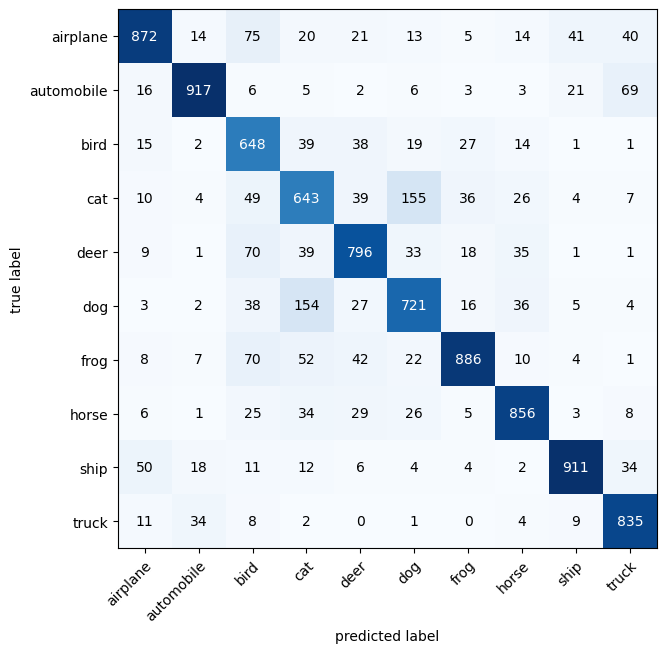

In [31]:
plot_confusion_matrix(confMat, figsize=(10,7), class_names=obj_class)

In [32]:
a = [1,2]

In [33]:
print(*a)

1 2


In [34]:
## saving model

torch.save(model0, "model_cifar_80_test.pth")